# Berkin Akar ML Individual project - 3102721 

This dataset is composed of 1000 samples with 35 features each. The first column
is the sample id. The second column in the dataset represents the label. There
are 3 possible values for the labels. The remaining columns are numeric
features.

Notice that the classes are unbalanced: some labels are more frequent than
others. You need to decide whether to take this into account, and if so how.

Your task is the following: you should compare the performance of Logistic
Regression (implemented by sklearn.linear_model.LogisticRegression) with that of
a Random Forest (implemented by sklearn.ensemble.RandomForestClassifier). Try to
optimize both algorithms' parameters and determine which one is best for this
dataset. At the end of the analysis, you should have chosen an algorithm and its
optimal set of parameters: write this choice explicitly in the conclusions of
your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).

## 1. Data

In [27]:
!pip install imblearn  

In [28]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import sklearn.cluster
from sklearn.preprocessing import scale
from sklearn import metrics
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import seaborn as sns
np.random.seed(42)

In [29]:
def generate_model_report(y_act , y_pred):
    print('Accuracy:', accuracy_score(y_act, y_pred))
    print('Precision:', precision_score(y_act, y_pred, average=None))
    print('Recall:', recall_score(y_act, y_pred,average=None))
    print('F1 score:', f1_score(y_act, y_pred,average=None))
    pass

In [30]:
df = pd.read_csv("mldata_0003102721.csv")

In [31]:
df.head()

,Unnamed: 0,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35
0,0,2,-1.820086,3.946530,-0.960497,4.691354,-10.455182,-0.589210,-3.904230,0.722087,...,2.752619,-1.181339,-0.282623,-0.932053,-0.043445,-8.150975,4.827469,-3.432825,0.091418,-6.370672
1,1,0,0.566837,6.315944,10.135066,2.206510,15.573732,11.370973,3.501418,5.012706,...,7.292952,11.934053,3.233310,11.550036,3.528903,6.159168,7.291273,6.958219,7.631250,11.497591
2,2,2,4.920958,15.045521,8.955917,15.139565,11.281443,12.924402,14.606815,14.533820,...,20.507146,10.966741,6.675262,12.830333,16.806753,3.884013,9.781241,7.240104,18.095873,18.262864
3,3,0,-1.416176,-4.794364,-7.676933,-5.616064,-9.116280,-4.753397,-0.483114,-4.703069,...,-3.505944,-5.290491,-3.736691,-5.905270,-3.710420,-0.568129,-9.202763,-6.274801,-11.625159,-8.836785
4,4,2,10.896301,18.673562,24.641354,13.873935,27.584951,25.354124,15.205430,22.874136,...,25.035989,25.859248,16.493639,33.179144,14.998601,21.079150,17.716957,20.308404,31.118538,29.883086


In [32]:
df = df.drop(df.columns[0], axis = 1)

We need to drop the first column, beacause it has no significance for our data and the model we will use

In [33]:
df.describe()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.22000,2.183833,4.649396,4.024110,3.788930,5.579464,5.122548,4.024177,4.623016,2.678287,...,5.205282,4.292272,2.962637,5.346971,3.615226,2.988988,3.412020,3.448169,5.859063,5.028119
std,0.89241,7.338306,9.483181,8.859002,8.768874,12.116464,11.321671,8.157153,10.337040,6.775234,...,10.990271,10.212809,7.974876,11.882626,8.663323,8.519078,8.723675,8.570326,14.056356,12.749359
min,0.00000,-20.631150,-35.989867,-31.430175,-29.685709,-38.422569,-36.760762,-26.726604,-36.529182,-16.259140,...,-39.955893,-38.135941,-22.540593,-39.607519,-27.240532,-23.851427,-30.647731,-27.330846,-45.258190,-37.792542
25%,0.00000,-2.667193,-2.106313,-1.813313,-1.721637,-2.727194,-2.398408,-1.036169,-2.480366,-2.281270,...,-2.219641,-2.445713,-2.744966,-2.353107,-2.110511,-3.001164,-2.552250,-2.560629,-3.591837,-3.656312
50%,2.00000,2.294861,4.930987,4.422949,4.830810,6.524495,5.616907,4.155176,5.022038,2.746526,...,5.620307,5.112013,3.500095,6.186298,3.432523,3.032372,4.080378,4.018957,6.633377,5.950063
75%,2.00000,7.339624,11.394603,10.096086,9.917448,13.482721,12.626700,9.364595,12.376094,7.517802,...,13.216717,11.200332,8.744591,13.136308,9.425616,8.783894,9.530324,9.280435,15.594917,13.692859
max,2.00000,24.480370,30.039416,31.726410,24.856953,43.282877,39.765462,27.268150,32.395003,25.829478,...,36.766254,36.520429,26.571216,44.869824,26.791424,26.800222,27.349174,30.104037,48.900807,41.886915


In [34]:
df.isnull().values.any()

False

In [35]:
np.any(df.duplicated())

False

In [36]:
print(df['label'].value_counts())

2    532
0    312
1    156
Name: label, dtype: int64


Text(0, 0.5, 'Number of Labels')

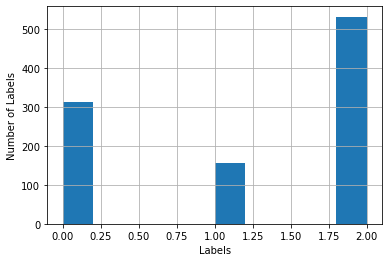

In [37]:
df['label'].hist()
plt.xlabel('Labels')
plt.ylabel('Number of Labels')

In [38]:
corr_matrix = df.corr()
corr_matrix["label"].sort_values(ascending=False)

label         1.000000
feature_4     0.305740
feature_21    0.285628
feature_12    0.277873
feature_32    0.252722
feature_29    0.247372
feature_16    0.241121
feature_27    0.239612
feature_28    0.236399
feature_22    0.235446
feature_2     0.232603
feature_6     0.228677
feature_34    0.226191
feature_20    0.224227
feature_35    0.222170
feature_33    0.220208
feature_30    0.219528
feature_13    0.219213
feature_3     0.217924
feature_8     0.206896
feature_17    0.196386
feature_25    0.194674
feature_24    0.193265
feature_9     0.191484
feature_26    0.168746
feature_10    0.164017
feature_7     0.156259
feature_5     0.142756
feature_31    0.131079
feature_11    0.118223
feature_14    0.116531
feature_15    0.113550
feature_23    0.109245
feature_19    0.099805
feature_18    0.095253
feature_1     0.084813
Name: label, dtype: float64

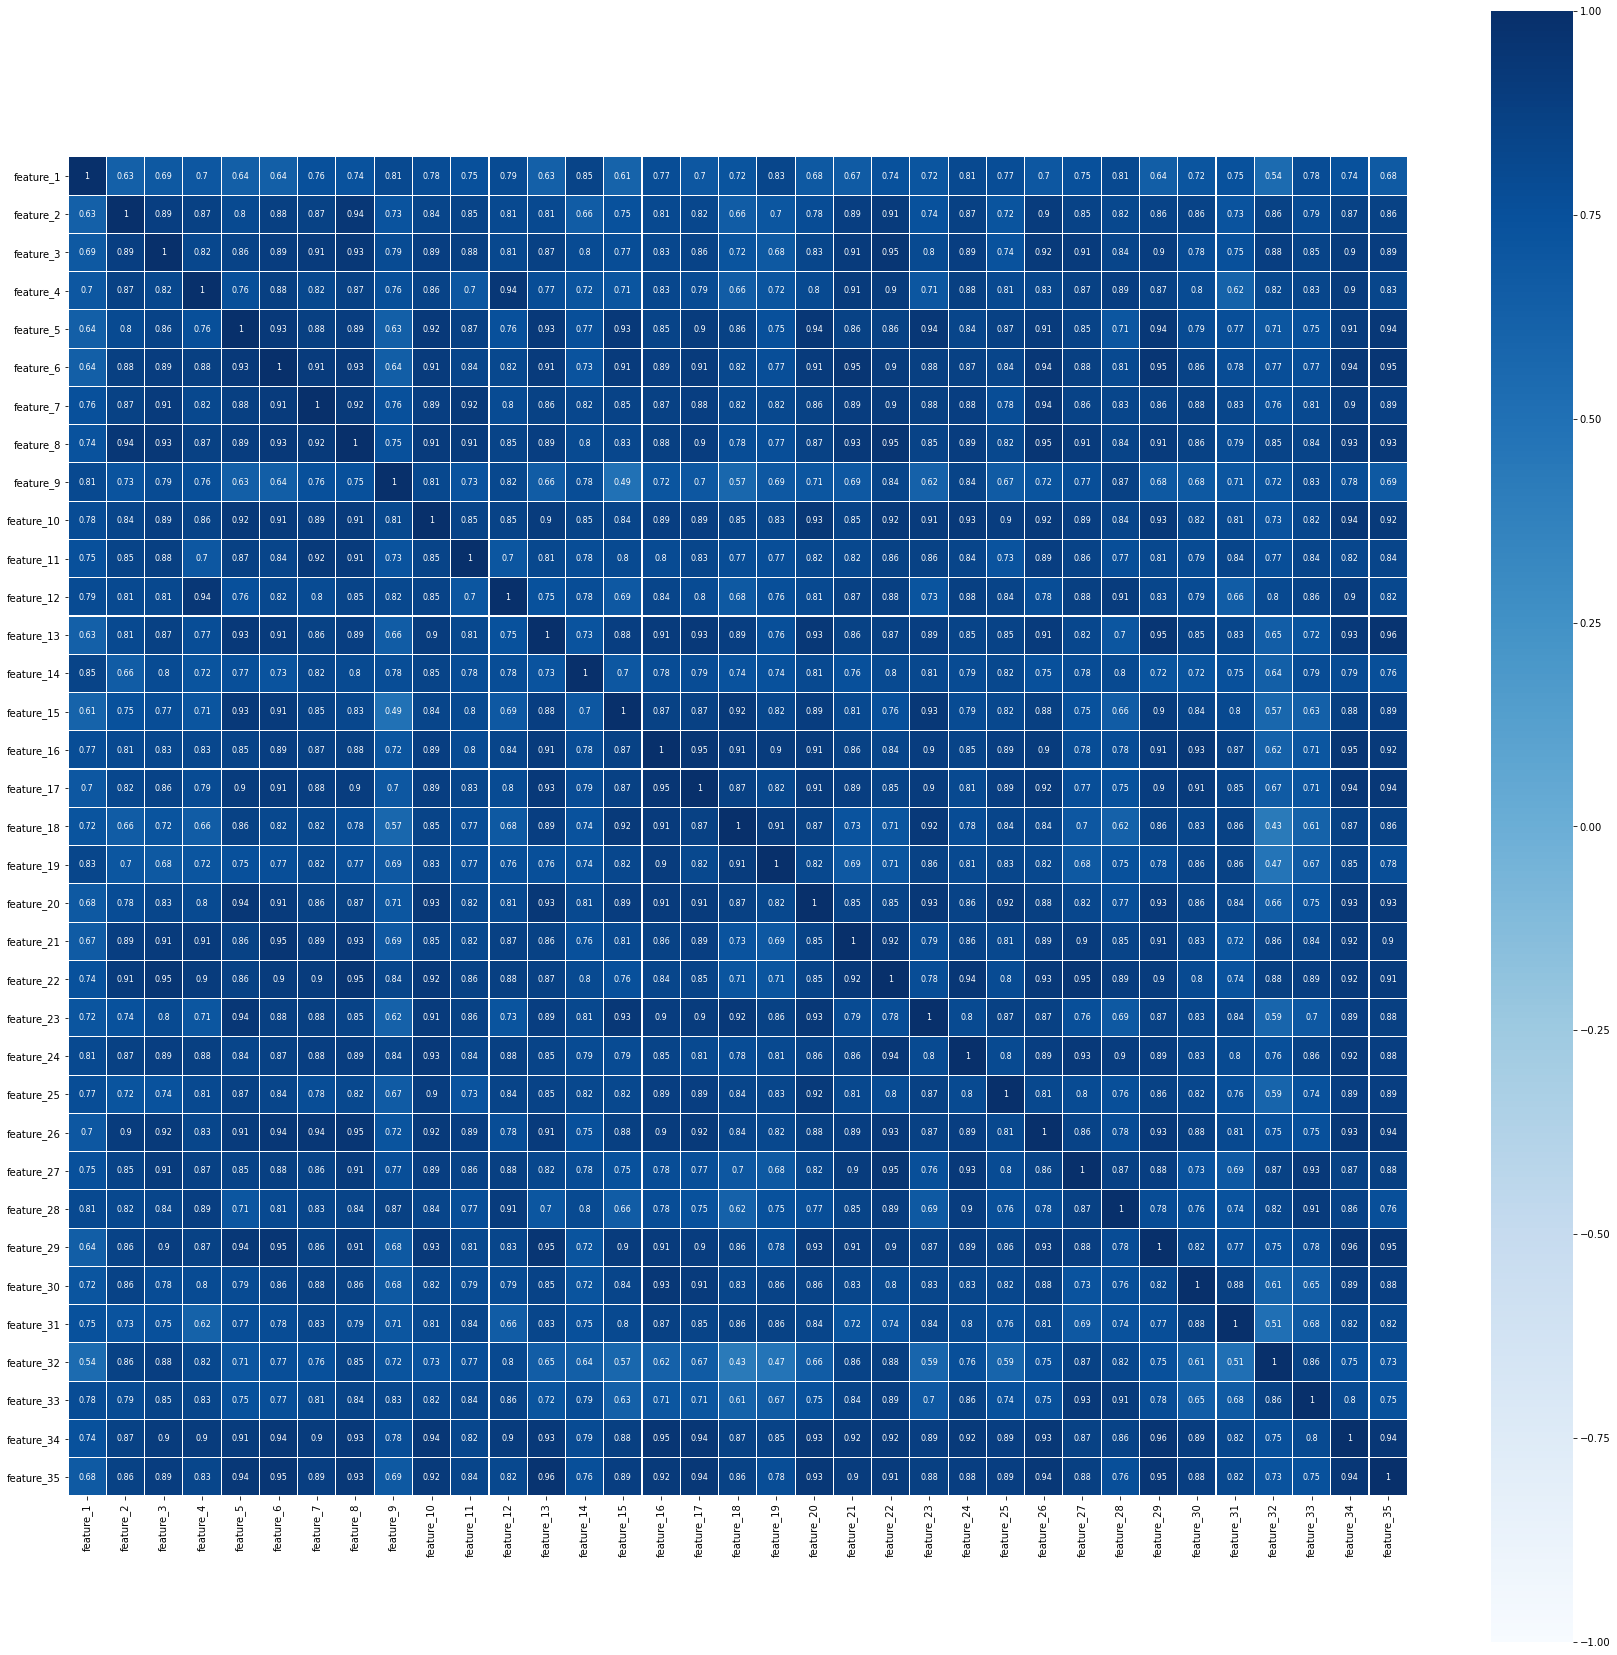

In [84]:
features = df.drop(df.columns[0], axis = 1)
corr_matrix = features.corr()
fig, axes = plt.subplots(figsize=(30,30))     
sns.heatmap(corr_matrix,cmap='Blues', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size":8}, square=True, ax=axes)
plt.show()

There are no empty values or duplicates in the data set to deal with. However there is an imbalance of labels which may be a problem, this will be taken into account.

However features are are highly correlated with each other which may produce collinearity problems

## 2. Train-Test split

In [83]:
X = df.drop(df.columns[0], axis = 1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35
0,-1.820086,3.946530,-0.960497,4.691354,-10.455182,-0.589210,-3.904230,0.722087,-2.843449,-5.378711,...,2.752619,-1.181339,-0.282623,-0.932053,-0.043445,-8.150975,4.827469,-3.432825,0.091418,-6.370672
1,0.566837,6.315944,10.135066,2.206510,15.573732,11.370973,3.501418,5.012706,0.725615,5.127737,...,7.292952,11.934053,3.233310,11.550036,3.528903,6.159168,7.291273,6.958219,7.631250,11.497591
2,4.920958,15.045521,8.955917,15.139565,11.281443,12.924402,14.606815,14.533820,5.119689,5.869271,...,20.507146,10.966741,6.675262,12.830333,16.806753,3.884013,9.781241,7.240104,18.095873,18.262864
3,-1.416176,-4.794364,-7.676933,-5.616064,-9.116280,-4.753397,-0.483114,-4.703069,-5.034287,-6.411885,...,-3.505944,-5.290491,-3.736691,-5.905270,-3.710420,-0.568129,-9.202763,-6.274801,-11.625159,-8.836785
4,10.896301,18.673562,24.641354,13.873935,27.584951,25.354124,15.205430,22.874136,16.292086,20.570942,...,25.035989,25.859248,16.493639,33.179144,14.998601,21.079150,17.716957,20.308404,31.118538,29.883086


### 2.1 Logistic Regression

In [41]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
LR_predict = model_1.predict(X_test)
accuracy_1 = accuracy_score(y_test, LR_predict)
print("the first test accuracy of Logistic Regression is:", accuracy_1)

the first test accuracy of Logistic Regression is: 0.61


/Users/akarberkin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
generate_model_report(y_test, LR_predict)

Accuracy: 0.61
Precision: [0.54347826 0.5        0.65151515]
Recall: [0.48076923 0.32352941 0.75438596]
F1 score: [0.51020408 0.39285714 0.69918699]


### 2.2 Random Forrest Classifier

In [43]:
model_2 = RandomForestClassifier()
model_2.fit(X_train, y_train)
rf_predict = model_2.predict(X_test)
accuracy_2 = accuracy_score(y_test, rf_predict)
print("the first test accuracy of Random Forrect Classifier is:", accuracy_2)

the first test accuracy of Random Forrect Classifier is: 0.66


In [44]:
generate_model_report(y_test, rf_predict)

Accuracy: 0.66
Precision: [0.54545455 0.75       0.6875    ]
Recall: [0.46153846 0.26470588 0.86842105]
F1 score: [0.5        0.39130435 0.76744186]


### 2.3 Oversampling

In [45]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [46]:
print(y.value_counts())

2    532
1    532
0    532
Name: label, dtype: int64


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [48]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
LR_predict = model_1.predict(X_test)
print('scores of Logistic Regression after oversampling:')
generate_model_report(y_test, LR_predict)

scores of Logistic Regression after oversampling:
Accuracy: 0.659375
Precision: [0.80555556 0.69444444 0.47115385]
Recall: [0.6796875  0.70754717 0.56976744]
F1 score: [0.73728814 0.70093458 0.51578947]


/Users/akarberkin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
model_2 = RandomForestClassifier()
model_2.fit(X_train, y_train)
rf_predict = model_2.predict(X_test)
print('scores of Random Forrest Classifier after oversampling:')
generate_model_report(y_test, rf_predict)

scores of Random Forrest Classifier after oversampling:
Accuracy: 0.81875
Precision: [0.84552846 0.85185185 0.74157303]
Recall: [0.8125     0.86792453 0.76744186]
F1 score: [0.82868526 0.85981308 0.75428571]


With oversampling, the number of samples for each label is the same at 532 prodcuing more accurate results (also higher precision and recall). The accuracy of the Logistic Regression model improved from 0.61 to 0.69 and the Precison, Recall and F1 scores increased substantially. Same can be said for the Random Forrest Classifier model, where when the number of labels were balanced, the accuracy increased to 0.82 from 0.66 with great increases for the corresponding Precison, Recall and F1 scores.

## 3. Classification

### 3.1 PCA with Normalizer

In [50]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
scaler.fit(X_train)

Normalizer()

In [51]:
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [52]:
from sklearn.decomposition import PCA
pca_95 = PCA(n_components=0.95)
pca_95.fit(X_train_scal)

PCA(n_components=0.95)

In [53]:
X_train_pca = pca_95.transform(X_train_scal)
X_test_pca = pca_95.transform(X_test_scal)

In [54]:
model_1 = LogisticRegression()
model_1.fit(X_train_pca, y_train)
lr_predict = model_1.predict(X_test_pca)
print('scores of Logistic Regression after PCA:')
generate_model_report(y_test, lr_predict)

scores of Logistic Regression after PCA:
Accuracy: 0.565625
Precision: [0.71134021 0.625      0.39495798]
Recall: [0.5390625  0.61320755 0.54651163]
F1 score: [0.61333333 0.61904762 0.45853659]


In [55]:
model_2 = RandomForestClassifier()
model_2.fit(X_train_pca, y_train)
rf_predict = model_2.predict(X_test_pca)
print('scores of Random Forrest Classifier after PCA:')
generate_model_report(y_test, rf_predict)

scores of Random Forrest Classifier after PCA:
Accuracy: 0.80625
Precision: [0.85470085 0.82142857 0.72527473]
Recall: [0.78125    0.86792453 0.76744186]
F1 score: [0.81632653 0.8440367  0.74576271]


Both models produce better results compared to when the lables were unbalanced, but actaully the oversampling approcah was better than using the Normalizer scaler.

### 3.2 PCA with MinMaxScaler

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()
scaler_mm.fit(X_train)

MinMaxScaler()

In [57]:
X_train_scal_mm = scaler_mm.transform(X_train)
X_test_scal_mm = scaler_mm.transform(X_test)
pca_95.fit(X_train_scal_mm)

PCA(n_components=0.95)

In [58]:
X_train_pca = pca_95.transform(X_train_scal_mm)
X_test_pca = pca_95.transform(X_test_scal_mm)

In [59]:
model_1 = LogisticRegression()
model_1.fit(X_train_pca, y_train)
lr_predict = model_1.predict(X_test_pca)
print('scores of Logistic Regression after MinMaxScaler:')
generate_model_report(y_test, lr_predict)

scores of Logistic Regression after MinMaxScaler:
Accuracy: 0.49375
Precision: [0.56435644 0.51376147 0.40909091]
Recall: [0.4453125  0.52830189 0.52325581]
F1 score: [0.49781659 0.52093023 0.45918367]


In [60]:
model_2 = RandomForestClassifier()
model_2.fit(X_train_pca, y_train)
rf_predict = model_2.predict(X_test_pca)
print('scores of Random Forrest Classifier after MinMaxScaler:')
generate_model_report(y_test, rf_predict)

scores of Random Forrest Classifier after MinMaxScaler:
Accuracy: 0.734375
Precision: [0.78151261 0.75454545 0.64835165]
Recall: [0.7265625  0.78301887 0.68604651]
F1 score: [0.75303644 0.76851852 0.66666667]


Both get slightly worse results than using the Normalizer. StandardScaler was also used, but produced lower results than the MinMaxScaler, therefore it is not present in the code.

### 3.3 GridSearch

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('pca', PCA()),
                           ('logistic_Reg', LogisticRegression())])
n_components = list(range(1,X_train.shape[1]+1,1))
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty,
                      logistic_Reg__solver = ['liblinear'])

In [69]:
log_cv = GridSearchCV(pipe, parameters)
log_cv.fit(X_train, y_train)
print('Best Penalty:', log_cv.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', log_cv.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', log_cv.best_estimator_.get_params()['pca__n_components'])
print(); print(log_cv.best_estimator_.get_params()['logistic_Reg'])
print("Score obtained through Logistic Regression is: ", log_cv.score(X_test, y_test))

Best Penalty: l1
Best C: 75.43120063354607
Best Number Of Components: 29

LogisticRegression(C=75.43120063354607, penalty='l1', solver='liblinear')
Score obtained through Logistic Regression is:  0.6625


In [70]:
pipe_random_forest = Pipeline([('scaler', StandardScaler()),('pca', PCA()),('rndfor', RandomForestClassifier())])
ranges = [300, 400, 500]
entropy = ['entropy']
parameters = {'rndfor__n_estimators': ranges, 'rndfor__criterion': entropy, }

In [63]:
randomforest = GridSearchCV(pipe_random_forest, parameters, cv=5 ,verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [64]:
print(randomforest.best_estimator_.get_params()['rndfor'])
print("Score obtained through RandomForest is: ", randomforest.score(X_test, y_test))

RandomForestClassifier(criterion='entropy', n_estimators=300)
Score obtained through RandomForest is:  0.871875


## 4. Extra: KNN Classifier

In [71]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
knn_predict = model.predict(X_test)
accuracy = accuracy_score(y_test, knn_predict)
generate_model_report(y_test, knn_predict)

Accuracy: 0.78125
Precision: [0.8015873  0.75757576 0.79032258]
Recall: [0.7890625  0.94339623 0.56976744]
F1 score: [0.79527559 0.84033613 0.66216216]


In [72]:
scaler = Normalizer()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)
pca_95.fit(X_train_scal)
X_train_pca = pca_95.transform(X_train_scal)
X_test_pca = pca_95.transform(X_test_scal)

In [73]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_pca,y_train)
knn_predict = model.predict(X_test_pca)
accuracy = accuracy_score(y_test, knn_predict)
generate_model_report(y_test, knn_predict)

Accuracy: 0.778125
Precision: [0.76296296 0.8        0.77142857]
Recall: [0.8046875  0.86792453 0.62790698]
F1 score: [0.78326996 0.83257919 0.69230769]


In [74]:
pipe = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', KNeighborsClassifier(algorithm='brute')) 
    ])
params = {
        'knn__n_neighbors': [3, 5, 7, 9, 11]
    }
clf = GridSearchCV(estimator=pipe,           
                      param_grid=params, 
                      cv=5,
                      return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='brute'))]),
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11]},
             return_train_score=True)

In [75]:
print(clf.best_params_)
print(clf.score(X_test,y_test))

{'knn__n_neighbors': 3}
0.778125


## 5. Peformance Check

In [85]:
from sklearn.metrics import classification_report

In [78]:
best_tree_classifier=randomforest.best_estimator_
best_tree_classifier.fit(X_train,y_train)

tree_prediction=best_tree_classifier.predict(X_test)
target_names = ['0', '1', '2']

print(classification_report(y_test, tree_prediction,target_names=target_names))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       128
           1       0.91      0.90      0.90       106
           2       0.76      0.79      0.77        86

    accuracy                           0.85       320
   macro avg       0.85      0.85      0.85       320
weighted avg       0.85      0.85      0.85       320



In [79]:
best_tree_classifier=log_cv.best_estimator_
best_tree_classifier.fit(X_train,y_train)

tree_prediction=best_tree_classifier.predict(X_test)
target_names = ['0', '1', '2']

print(classification_report(y_test, tree_prediction,target_names=target_names))

              precision    recall  f1-score   support

           0       0.80      0.70      0.74       128
           1       0.68      0.71      0.69       106
           2       0.48      0.56      0.52        86

    accuracy                           0.66       320
   macro avg       0.66      0.65      0.65       320
weighted avg       0.68      0.66      0.67       320



In [80]:
best_tree_classifier=clf.best_estimator_
best_tree_classifier.fit(X_train,y_train)

tree_prediction=best_tree_classifier.predict(X_test)
target_names = ['0', '1', '2']

print(classification_report(y_test, tree_prediction,target_names=target_names))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       128
           1       0.73      0.92      0.82       106
           2       0.84      0.57      0.68        86

    accuracy                           0.78       320
   macro avg       0.79      0.76      0.76       320
weighted avg       0.79      0.78      0.77       320



## 6. Conclusion

After careful consideration of the data, the optimal paramter for the Logistic Regression model can be seen from LogisticRegression(C=75.43120063354607, penalty='l1', solver='liblinear') with an accuracy score of 0.66.

In the other hand the optimal parameters for the Random Forrest Classifier can be seen from RandomForestClassifier(criterion='entropy', n_estimators=300) with an accuracy score of 0.87

In addition, the oversampling through the imblearn model and the SMOTE database helped both models imporve their accuracy in addition to their precision and recall scores. This was done due to the imbalance of the number of data for each label.

From this analysis, it is seen the RandomForrestClassifier is the better model to use for the given data and the accuracy, precison, recall and F1 scores from both models under different considerations.

From the extra model used (KNN classifier) it is seen that it is more optimal than the Logistic Regression model, but performs worse than the Random Forrest Classifier. The Grid Search provides the best paramters for it is n_neigbours = 3 with an accuracy score of 0.78.